In [1]:
%pip install python-docx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 5.0 MB/s eta 0:00:00


In [2]:
import os
import zipfile
import pandas as pd
from docx import Document
# Path to your uploaded zip file
zip_path = "/content/P567 Dataset.zip"
extract_to = "/content/P567_Dataset"

# Extract the zip file
os.makedirs(extract_to, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Dataset extracted to:", extract_to)

Dataset extracted to: /content/P567_Dataset


In [3]:
texts, labels = [], []

for root, dirs, files in os.walk(extract_to):
    label = os.path.basename(root)  # folder name is the label
    for f in files:
        if f.endswith(".docx"):
            file_path = os.path.join(root, f)
            try:
                doc = Document(file_path)
                text = " ".join([p.text for p in doc.paragraphs])
                texts.append(text)
                labels.append(label)
            except Exception as e:
                print("Error reading:", file_path, "|", e)

# Build DataFrame
df = pd.DataFrame({"resume_text": texts, "category": labels})
print("Data shape:", df.shape)
df.head()


Error reading: /content/P567_Dataset/P-561 Dataset/Resumes_Docx/Peoplesoft/Peoplesoft Admin_G Ananda Rayudu.docx | "no relationship of type 'http://schemas.openxmlformats.org/officeDocument/2006/relationships/officeDocument' in collection"
Data shape: (52, 2)


,resume_text,category
0,RAJU PAVANA KUMARI Professional Summary: Ha...,SQL Developer
1,ANIL KUMAR MADDUKURI \t\t SQL & MSBI Develope...,SQL Developer
2,KAMBALLA PRADEEP ...,SQL Developer
3,BUDDHA VAMSI ...,SQL Developer
4,SQL DEVELOPER Name: - Bandi prem sai Willi...,SQL Developer


# ***EDA***

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   resume_text  52 non-null     object
 1   category     52 non-null     object
 2   text_length  52 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.3+ KB
None

Category counts:
 category
React Developer      20
SQL Developer        11
workday              11
Peoplesoft Resume    10
Name: count, dtype: int64

Text length stats:
 count       52.000000
mean      4037.557692
std       2397.611625
min        994.000000
25%       2618.000000
50%       3633.500000
75%       5089.000000
max      15339.000000
Name: text_length, dtype: float64

Sample text:
  RAJU PAVANA KUMARI   Professional Summary: Having 2.10 years of Professional experience in SQL Server 2014/2017. Having experience in creating database objects such as Stored Procedures, Functions, Views,Indexes,Joins to facilitate efficient

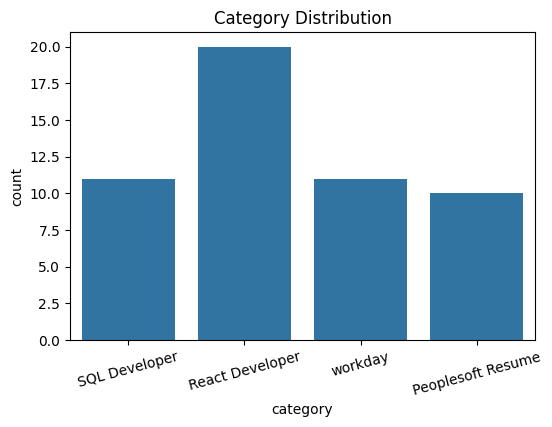

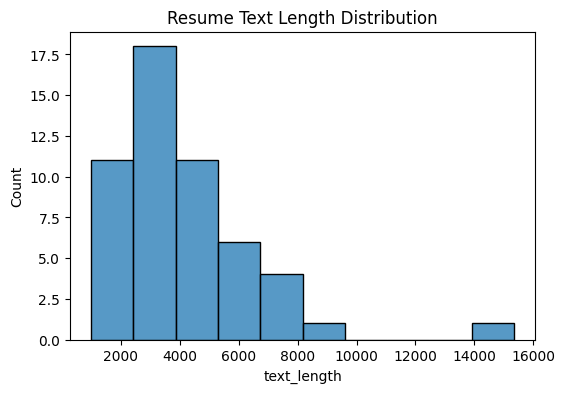

In [4]:
# --- Basic EDA ---

import matplotlib.pyplot as plt
import seaborn as sns

# Calculate text_length before using it
df['text_length'] = df['resume_text'].apply(len)

print(df.info())
print("\nCategory counts:\n", df['category'].value_counts())
print("\nText length stats:\n", df['text_length'].describe())
if len(df) > 0:
    print("\nSample text:\n", df['resume_text'].iloc[0][:500])


plt.figure(figsize=(6,4))
sns.countplot(x='category', data=df)
plt.title("Category Distribution")
plt.xticks(rotation=15)
plt.show()


plt.figure(figsize=(6,4))
sns.histplot(df['text_length'], bins=10)
plt.title("Resume Text Length Distribution")
plt.show()

# ***EDA: Visualizations***

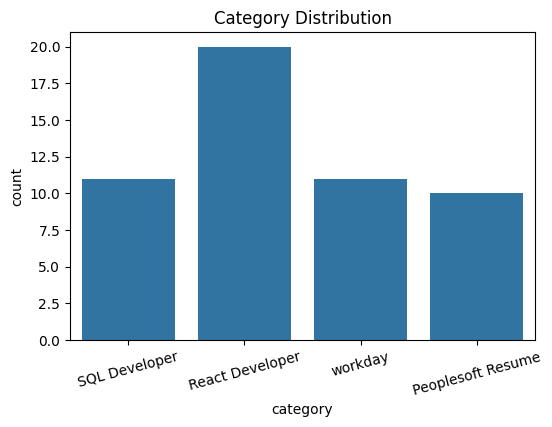

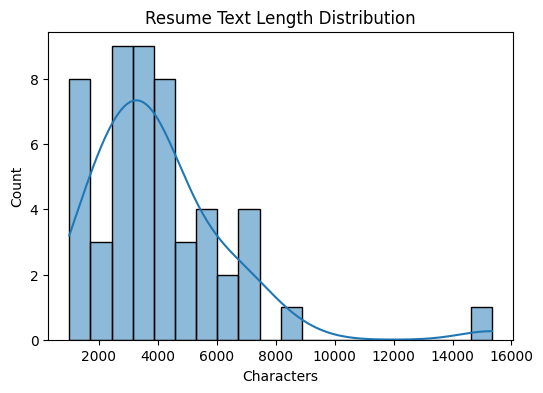

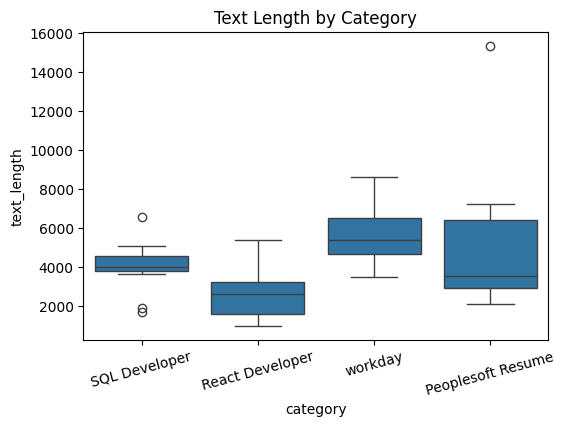

In [5]:
# --- EDA: Visualizations ---

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='category', data=df)
plt.title("Category Distribution")
plt.xticks(rotation=15)
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(df['text_length'], bins=20, kde=True)
plt.title("Resume Text Length Distribution")
plt.xlabel("Characters")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x='category', y='text_length', data=df)
plt.title("Text Length by Category")
plt.xticks(rotation=15)
plt.show()


# ***CLEAN TEXT***

In [6]:
# --- Clean text ---

import re

df['resume_text_clean'] = (
    df['resume_text']
      .fillna('')
      .astype(str)
      .apply(lambda t: re.sub(r'[^a-z0-9 ]', ' ', t.lower()).strip())
)

# drop empties after cleaning
df = df[df['resume_text_clean'].str.strip() != '']

X_text = df['resume_text_clean']
y = df['category']
print("After cleaning:", df.shape)


After cleaning: (52, 4)


# ***TF-IDF***

In [7]:

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=3000,
    token_pattern=r'(?u)\b\w+\b',
    min_df=1
)
X_tfidf = vectorizer.fit_transform(X_text)
print("TF-IDF shape:", X_tfidf.shape)


TF-IDF shape: (52, 3000)


# ***FEATURE ENGINEERING***

In [8]:

import numpy as np
from scipy.sparse import hstack

word_count  = X_text.apply(lambda s: len(s.split())).values.reshape(-1,1)
char_count  = X_text.apply(len).values.reshape(-1,1)
avg_wordlen = (char_count / (word_count + 1)).reshape(-1,1)  # safe divide

X_final = hstack([X_tfidf, word_count, char_count, avg_wordlen])
print("Final features shape:", X_final.shape)


Final features shape: (52, 3003)


# ***TRAIN TEST SPLIT***

In [9]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)


print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)


Train shape: (41, 3003) | Test shape: (11, 3003)


In [10]:
from scipy.sparse import hstack
import numpy as np


# Word count and average word length
word_count = df['resume_text_clean'].apply(lambda x: len(x.split())).values.reshape(-1,1)
char_count = df['resume_text_clean'].apply(len).values.reshape(-1,1)
avg_word_len = (char_count / (word_count+1)).reshape(-1,1)  # avoid division by zero

X_final = hstack([X_tfidf, word_count, char_count, avg_word_len])

print("Original TF-IDF shape:", X_tfidf.shape)
print("After adding extra features:", X_final.shape)

Original TF-IDF shape: (52, 3000)
After adding extra features: (52, 3003)


# ***MODEL BUILDING***

In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def evaluate_and_visualize(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds)
    print(f"\n{name} Accuracy: {acc:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, preds))

    # confusion matrix
    labels_sorted = sorted(y_test.unique())
    cm = confusion_matrix(y_test, preds, labels=labels_sorted)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels_sorted, yticklabels=labels_sorted)
    plt.title(f"{name} – Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout(); plt.show()

    #  precision/recall/f1
    rep = classification_report(y_test, preds, output_dict=True)
    metrics_df = pd.DataFrame(rep).transpose().iloc[:-3, :3]
    ax = metrics_df.plot(kind='bar', figsize=(6,4))
    ax.set_title(f"{name} – Precision / Recall / F1"); ax.set_ylim(0,1)
    plt.tight_layout(); plt.show()

    return acc


# ***LOGISTIC REGRESSION***

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Accuracy: 0.636

Classification Report:
                   precision    recall  f1-score   support

Peoplesoft Resume       0.50      0.50      0.50         2
  React Developer       0.75      0.75      0.75         4
    SQL Developer       1.00      0.33      0.50         3
          workday       0.50      1.00      0.67         2

         accuracy                           0.64        11
        macro avg       0.69      0.65      0.60        11
     weighted avg       0.73      0.64      0.62        11



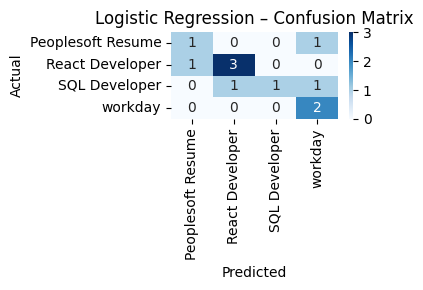

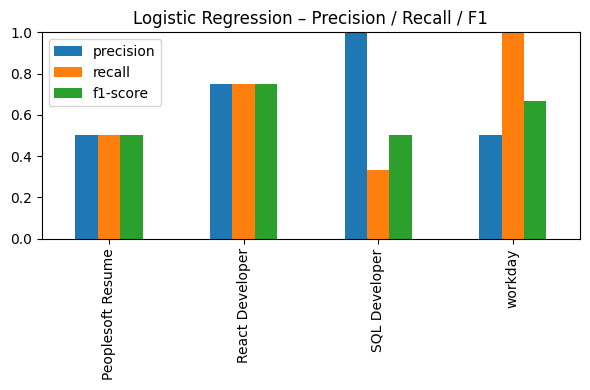

In [12]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_acc = evaluate_and_visualize(log_reg, X_train, X_test, y_train, y_test, "Logistic Regression")


# ***DECISION TREE***


Decision Tree Accuracy: 1.000

Classification Report:
                   precision    recall  f1-score   support

Peoplesoft Resume       1.00      1.00      1.00         2
  React Developer       1.00      1.00      1.00         4
    SQL Developer       1.00      1.00      1.00         3
          workday       1.00      1.00      1.00         2

         accuracy                           1.00        11
        macro avg       1.00      1.00      1.00        11
     weighted avg       1.00      1.00      1.00        11



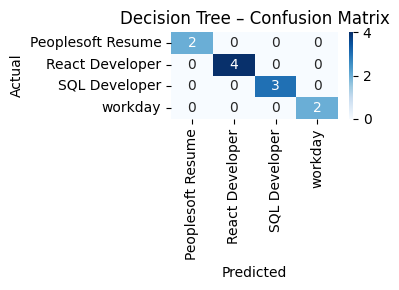

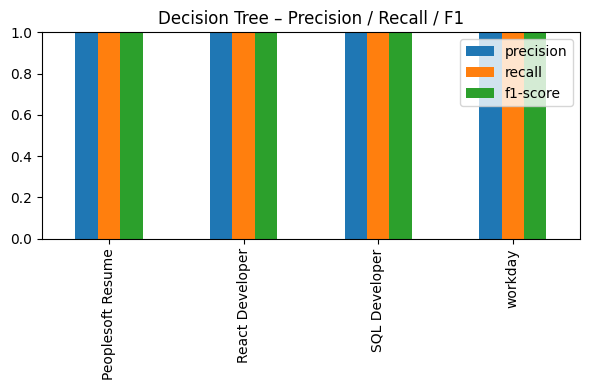

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)

dt = DecisionTreeClassifier(random_state=42)
dt_acc = evaluate_and_visualize(dt, X_train, X_test, y_train, y_test, "Decision Tree")



# ***RANDOM FOREST***


Random Forest Accuracy: 1.000

Classification Report:
                   precision    recall  f1-score   support

Peoplesoft Resume       1.00      1.00      1.00         2
  React Developer       1.00      1.00      1.00         4
    SQL Developer       1.00      1.00      1.00         3
          workday       1.00      1.00      1.00         2

         accuracy                           1.00        11
        macro avg       1.00      1.00      1.00        11
     weighted avg       1.00      1.00      1.00        11



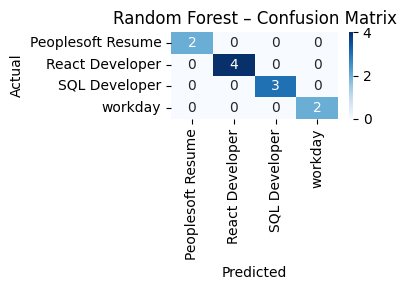

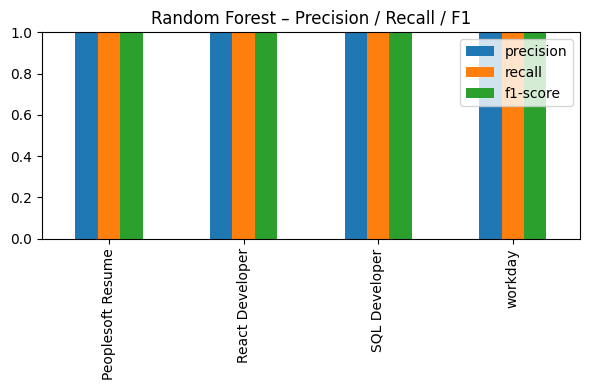

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)


rf = RandomForestClassifier(random_state=42, class_weight="balanced")
rf_acc = evaluate_and_visualize(rf, X_train, X_test, y_train, y_test, "Random Forest")

# ***SVM***


SVM Accuracy: 0.545

Classification Report:
                   precision    recall  f1-score   support

Peoplesoft Resume       0.33      0.50      0.40         2
  React Developer       0.75      0.75      0.75         4
    SQL Developer       0.00      0.00      0.00         3
          workday       0.50      1.00      0.67         2

         accuracy                           0.55        11
        macro avg       0.40      0.56      0.45        11
     weighted avg       0.42      0.55      0.47        11



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


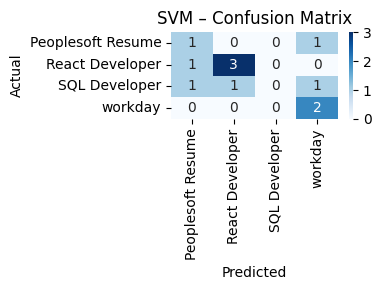

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


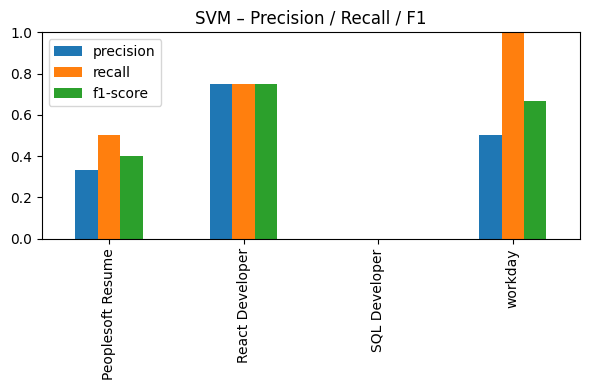

In [15]:
from sklearn.svm import SVC

svm_clf = SVC(kernel='linear', random_state=42)
svm_acc = evaluate_and_visualize(svm_clf, X_train, X_test, y_train, y_test, "SVM")


# ***MODEL COMPARSION***

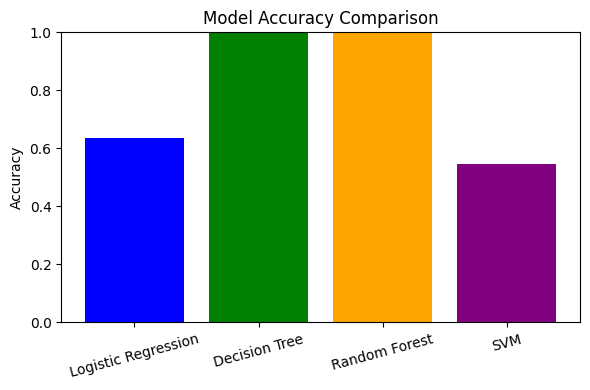

Best model: Decision Tree | Accuracy: 1.0


In [16]:
import matplotlib.pyplot as plt

accuracies = {
    'Logistic Regression': log_acc,
    'Decision Tree': dt_acc,
    'Random Forest': rf_acc,
    'SVM': svm_acc
}

plt.figure(figsize=(6,4))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue','green','orange','purple'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

best_model = max(accuracies, key=accuracies.get)
print("Best model:", best_model, "| Accuracy:", round(accuracies[best_model], 3))


# ***MODEL DEPLOYMENT***

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
import joblib
from sklearn.model_selection import train_test_split


pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=3000, token_pattern=r'(?u)\b\w+\b', min_df=1)),
    ("clf", DecisionTreeClassifier(random_state=42, class_weight="balanced"))
])

X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

pipeline.fit(X_train, y_train)

joblib.dump(pipeline, "decision_tree_pipeline.pkl")
print(" Pipeline saved!")

 Pipeline saved!
